#  CE-40959: Deep Learning

## Homework 5 - 1: VAE

The goal is to VAE!!!!

Good luck

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

---

In [0]:
CUDA = True
BATCH_SIZE = 128
LEARNING_RATE = 0.07

---

In [0]:
# Reproducibility options

np.random.seed(0)
torch.manual_seed(0)

if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

---

In [6]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21086858.31it/s]                            


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 323688.90it/s]                           
0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5128084.24it/s]                           
8192it [00:00, 130244.75it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
# Define Train loader
train_tensors = original_train_dataset.data.float() / 255
test_tensors = original_test_dataset.data.float() / 255

# Define Datasets
train_dataset = torch.utils.data.TensorDataset(train_tensors, original_train_dataset.targets)
test_dataset = torch.utils.data.TensorDataset(test_tensors, original_test_dataset.targets)

# Define dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

---

In [0]:
class VAE(nn.Module):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims, dropout_rate=0.2):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.z_dim = z_dim
        
        ########################## TODO ##########################
        # self.input_dropout must be a dropout module with p=dropout_rate
        self.input_dropout = nn.Dropout(p=dropout_rate)
        #self.input_dropout = nn.modules
        ######################## END TODO ########################
        
        # Encoder part
        encoder_layers = []
        ########################## TODO ##########################
        # Define encoder layers and add them to `encoder_layers`
        # Use ReLU for activation functions
        last_layer_dim=input_dim
        for encoder_dim in encoder_dims:
          encoder_layers.append(nn.Linear(last_layer_dim,encoder_dim,bias=True))
          encoder_layers.append(nn.ReLU())
          last_layer_dim=encoder_dim
        
        ######################## END TODO ########################
        self.encoder = nn.Sequential(*encoder_layers)
        
        encoder_last_dim = ([input_dim] + encoder_dims)[-1]
        
        # mu and log_var
        ########################## TODO ##########################
        # Define mu and log_var layers
        # They do not need any activation function
        self.mu_layer = nn.Linear(encoder_last_dim,z_dim)
        self.log_var_layer = nn.Linear(encoder_last_dim,z_dim)
        
        ######################## END TODO ########################
        
        # Decoder part
        decoder_layers = []
        ########################## TODO ##########################
        # Define decoder layers and add them to `decoder_layers`
        # Use ReLU for activation functions
        # Last layer does not need any activation function
        
        last_layer_dim=z_dim
        for decoder_dim in decoder_dims:
          decoder_layers.append(nn.Linear(last_layer_dim,decoder_dim,bias=True))
          decoder_layers.append(nn.ReLU())
          last_layer_dim=decoder_dim
        
        
        decoder_layers.append(nn.Linear(last_layer_dim,input_dim,bias=True))
        ######################## END TODO ########################
        self.decoder = nn.Sequential(*decoder_layers)
        

    @staticmethod
    def _sampling(mu,log_var):
        """
        This function is in charge of reparametrization trick
        """
        ########################## TODO ##########################
        # Generate a random z from N(mu=mu, var=e^log_var)
        
        my_distriubtion = torch.distributions.multivariate_normal.MultivariateNormal( torch.zeros(mu.shape[1]), covariance_matrix= torch.eye(mu.shape[1])   )
        z=my_distriubtion.sample((mu.shape[0],)).cuda()*torch.exp(log_var)+mu
        
        #my_distriubtion = torch.distributions.multivariate_normal.MultivariateNormal( torch., covariance_matrix=torch.diag(torch.exp(self.log_var)  )  ).
        #z = my_distribution.rsample()
        
        
        
        ######################## END TODO ########################
        return z

    def forward(self, data):
        x = data.get("X")
        ########################## TODO ##########################
        x_drop_outed = self.input_dropout(x)
        x_encoded = self.encoder(x_drop_outed)
        mu = self.mu_layer(x_encoded)
        log_var = self.log_var_layer(x_encoded)
        z=self._sampling(mu,log_var)
        output=self.decoder(z)
        
        
        
        
        # Complete the flow
        # x > dropout > encoder > mu, log_var > z > decoder > output
        
        ######################## END TODO ########################
        return {"X": output, "mu": mu, "log_var": log_var, "z": z}
    
    def loss(self, data, output):
      x = data.get("X")
      recon_x = output.get("X")
      mu = output.get("mu")
      log_var = output.get("log_var")
      ########################## TODO ##########################
      # Calculate MSE and KLD
      
      MSE = torch.nn.MSELoss(reduction='sum')(recon_x,x)
      
      KLD = torch.sum( -log_var + 1/2*(torch.pow(torch.exp(log_var),2) + torch.pow(mu,2) -1 ), dim=(0,1) )
      
      ######################## END TODO ########################
      return {"final": MSE + KLD, "KLD": KLD, "MSE": MSE}

---

In [0]:
def train(model, data_loader, optimizer, epoch="?", print_every=100, verbose=True):
    """
    This function trains a `model` given a `data_loader` by `optimizer`
    """
    model.train()

    train_loss = 0

    for batch_idx, batch_data in enumerate(data_loader):
        supervised_training = len(batch_data) == 2

        if supervised_training:
            # Labeled data
            data = {"X": batch_data[0],
                    "Y": batch_data[1]}
        else:
            # Unlabeled data
            data = {"X": batch_data[0]}

        # Flatten data
        ########################## TODO ##########################
        data["X"]=torch.flatten(data["X"],start_dim=1)
        ######################## END TODO ########################

        if CUDA:
            ########################## TODO ##########################
            # Send tensors in data to GPU
            data["X"]=data["X"].cuda()
            data["Y"]=data["Y"].cuda()
            ######################## END TODO ########################


        ########################## TODO ##########################
        # Think about this part
        ######################## END TODO ########################
        optimizer.zero_grad()

        output = model(data)
        loss = model.loss(data, output)
        final_loss = loss["final"]
        train_loss += final_loss.item()

        final_loss.backward()
        optimizer.step()
        ########################## TODO ##########################
        # Thinking ends here
        ######################## END TODO ########################

        if batch_idx % print_every == 0 and verbose:
            print('Train | Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data["X"]), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), final_loss.item() / len(data["X"])))

    train_loss /= len(data_loader.dataset)
    if verbose:
        print('====> Train | Epoch: {} \t | \t Average loss: {:.4f}'.format(epoch, train_loss,))

    return {"final": train_loss}

In [0]:
def test(model, data_loader, verbose=True):
    """
    This function tests a `model` on a `data_loader`
    """
    model.eval()

    test_loss = 0

    labels, y_preds = None, None
    with torch.no_grad():
        for batch_data  in data_loader:
            supervised = len(batch_data) == 2

            if supervised:
                # Labeled data
                data = {"X": batch_data[0],
                        "Y": batch_data[1]}
            else:
                # Unlabeled data
                data = {"X": batch_data[0]}

            #  Flatten data
            ########################## TODO ##########################
            # Use `flatten` function from pytorch
            data["X"]=torch.flatten(data["X"],start_dim=1)
            ######################## END TODO ########################

            if CUDA:
                ########################## TODO ##########################
                # Send tensors in data to GPU
                data["X"]=data["X"].cuda()
                data["Y"]=data["Y"].cuda()
                ######################## END TODO ########################

            output = model(data)
            loss = model.loss(data, output)
            final_loss = loss["final"]
            test_loss += final_loss.item()

            # Storing y_true and y_pred if learning is supervised
            supervised = supervised and "Y" in output
            if supervised:
                y_pred = np.argmax(output["Y"].detach().cpu().numpy(), axis=1)
                y_true = data["Y"].cpu().numpy()
                if labels is None:
                    labels = y_true
                    y_preds = y_pred
                else:
                    labels = np.concatenate((labels, y_true), axis=None)
                    y_preds = np.concatenate((y_preds, y_pred), axis=None)

    test_loss /= len(data_loader.dataset)

    if supervised:
        accuracy = accuracy_score(labels, y_preds)
        if verbose:
            print('====> Test  | model loss: {:.4f}'.format(test_loss))
            print('            |   accuracy: {:.4f}'.format(100 * accuracy))
            print(classification_report(labels, y_preds))
        return {"final": test_loss, "accuracy": accuracy}
    else:
        if verbose:
            print('====> Test  | model loss: {:.4f}'.format(test_loss))
        return {"final": test_loss}

In [0]:
def run(model, parameters, n_epoch, train_loader, test_loader,
        end_function=lambda model:None):
    """
    This function will optimize `parameters` of `model` for `n_epoch` epochs
    on `train_loader` dataset and validate it on `test_loader`.
    At the end of each epoch, `end_function` will be called on `model`.
    """
    if CUDA:
        model.cuda()

    ########################## TODO ##########################
    # Initialize a new Adam optimizer.
    # Set learning rate to LEARNING_RATE / BATCH_SIZE (why?)
    optimizer = optim.Adam(params=parameters,lr=LEARNING_RATE / BATCH_SIZE)
    ######################## END TODO ########################

    for epoch in range(1, n_epoch + 1):
        train_loss = train(model, train_loader, optimizer, epoch)
        test_loss = test(model, test_loader)
        end_function(model)

In [0]:
def show(image_batch, rows=1):
    # Set Plot dimensions
    cols = np.ceil(image_batch.shape[0] / rows)
    plt.rcParams['figure.figsize'] = (0.0 + cols, 0.0 + rows) # set default size of plots
    
    for i in range(image_batch.shape[0]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
        plt.axis('off')
    plt.show()

---

In [13]:
vae = VAE(784, encoder_dims=[512, 128], z_dim=32, decoder_dims=[128, 512])
print(vae)

# Output might be like:
# VAE(
#   (input_dropout): Dropout(p=0.2)
#   (encoder): Sequential(
#     (0): Linear(in_features=784, out_features=512, bias=True)
#     (1): ReLU()
#     (2): Linear(in_features=512, out_features=128, bias=True)
#     (3): ReLU()
#   )
#   (mu_layer): Linear(in_features=128, out_features=32, bias=True)
#   (log_var_layer): Linear(in_features=128, out_features=32, bias=True)
#   (decoder): Sequential(
#     (0): Linear(in_features=32, out_features=128, bias=True)
#     (1): ReLU()
#     (2): Linear(in_features=128, out_features=512, bias=True)
#     (3): ReLU()
#     (4): Linear(in_features=512, out_features=784, bias=True)
#   )
# )

VAE(
  (input_dropout): Dropout(p=0.2)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
  )
  (mu_layer): Linear(in_features=128, out_features=32, bias=True)
  (log_var_layer): Linear(in_features=128, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [0]:
def show_vae(vae):
    # Select 10 random inputs
    data_loader = train_loader
    indices = torch.randint(data_loader.dataset.tensors[0].shape[0], (10,))
    input_img = data_loader.dataset.tensors[0][indices]
    print("Inputs:")
    show(input_img.numpy())
    # Calculate reconstructions
    input_img = input_img.flatten(start_dim=1)
    if CUDA:
        input_img = input_img.cuda()
    recons_img = vae({"X": input_img})["X"]
    recons_img = recons_img.detach().cpu().view(-1, 28, 28).numpy()
    print("Reconstructions:")
    show(recons_img)
    # Generate images
    z = torch.randn(10, vae.z_dim)
    if CUDA:
        z = z.cuda()
    generated_img = vae.decoder(z)
    generated_img = generated_img.detach().cpu().view(-1, 28, 28).numpy()
    print("Generated Images:")
    show(generated_img)

Train | Epoch: 1 [0/60000 (0%)]	Loss: 97.343506
Train | Epoch: 1 [12800/60000 (21%)]	Loss: 54.834179
Train | Epoch: 1 [25600/60000 (43%)]	Loss: 51.805771
Train | Epoch: 1 [38400/60000 (64%)]	Loss: 48.791451
Train | Epoch: 1 [51200/60000 (85%)]	Loss: 46.540771
====> Train | Epoch: 1 	 | 	 Average loss: 49.4615
====> Test  | model loss: 42.5903
Inputs:


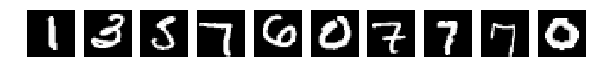

Reconstructions:


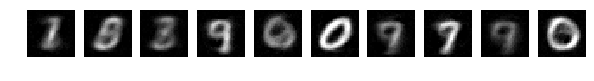

Generated Images:


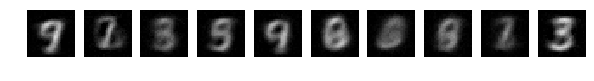

Train | Epoch: 2 [0/60000 (0%)]	Loss: 43.246487
Train | Epoch: 2 [12800/60000 (21%)]	Loss: 41.327522
Train | Epoch: 2 [25600/60000 (43%)]	Loss: 39.124809
Train | Epoch: 2 [38400/60000 (64%)]	Loss: 37.443977
Train | Epoch: 2 [51200/60000 (85%)]	Loss: 37.798103
====> Train | Epoch: 2 	 | 	 Average loss: 39.1971
====> Test  | model loss: 36.2790
Inputs:


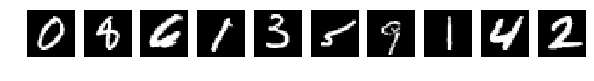

Reconstructions:


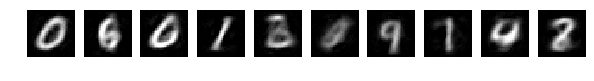

Generated Images:


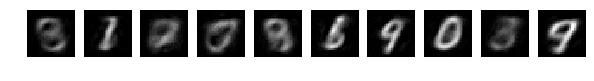

Train | Epoch: 3 [0/60000 (0%)]	Loss: 35.747654
Train | Epoch: 3 [12800/60000 (21%)]	Loss: 35.853786
Train | Epoch: 3 [25600/60000 (43%)]	Loss: 36.031933
Train | Epoch: 3 [38400/60000 (64%)]	Loss: 33.157909
Train | Epoch: 3 [51200/60000 (85%)]	Loss: 35.097458
====> Train | Epoch: 3 	 | 	 Average loss: 35.5916
====> Test  | model loss: 34.2605
Inputs:


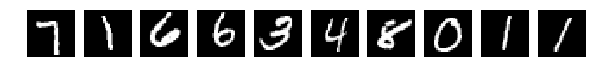

Reconstructions:


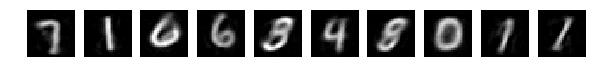

Generated Images:


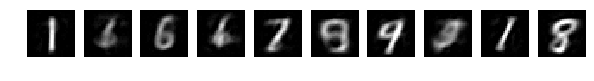

Train | Epoch: 4 [0/60000 (0%)]	Loss: 34.969795
Train | Epoch: 4 [12800/60000 (21%)]	Loss: 34.331394
Train | Epoch: 4 [25600/60000 (43%)]	Loss: 33.645393
Train | Epoch: 4 [38400/60000 (64%)]	Loss: 33.660267
Train | Epoch: 4 [51200/60000 (85%)]	Loss: 33.833893
====> Train | Epoch: 4 	 | 	 Average loss: 34.1838
====> Test  | model loss: 33.1381
Inputs:


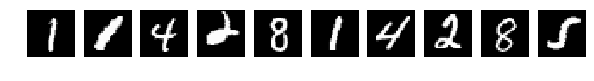

Reconstructions:


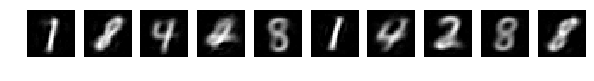

Generated Images:


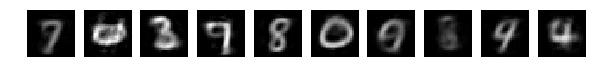

Train | Epoch: 5 [0/60000 (0%)]	Loss: 34.069149
Train | Epoch: 5 [12800/60000 (21%)]	Loss: 33.745674
Train | Epoch: 5 [25600/60000 (43%)]	Loss: 33.488914
Train | Epoch: 5 [38400/60000 (64%)]	Loss: 32.867294
Train | Epoch: 5 [51200/60000 (85%)]	Loss: 32.004219
====> Train | Epoch: 5 	 | 	 Average loss: 33.1584
====> Test  | model loss: 32.1774
Inputs:


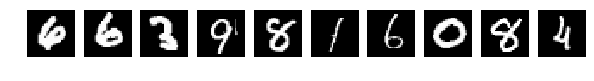

Reconstructions:


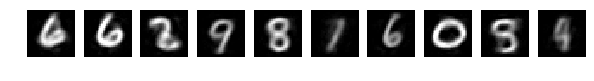

Generated Images:


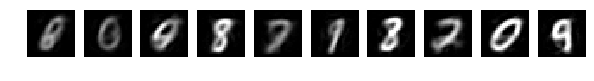

Train | Epoch: 6 [0/60000 (0%)]	Loss: 31.862106
Train | Epoch: 6 [12800/60000 (21%)]	Loss: 32.357311
Train | Epoch: 6 [25600/60000 (43%)]	Loss: 32.345036
Train | Epoch: 6 [38400/60000 (64%)]	Loss: 31.412708
Train | Epoch: 6 [51200/60000 (85%)]	Loss: 32.036293
====> Train | Epoch: 6 	 | 	 Average loss: 32.3732
====> Test  | model loss: 31.5923
Inputs:


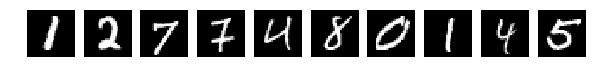

Reconstructions:


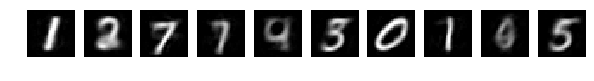

Generated Images:


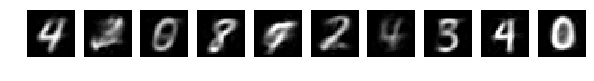

Train | Epoch: 7 [0/60000 (0%)]	Loss: 32.829029
Train | Epoch: 7 [12800/60000 (21%)]	Loss: 32.086349
Train | Epoch: 7 [25600/60000 (43%)]	Loss: 32.396633
Train | Epoch: 7 [38400/60000 (64%)]	Loss: 32.425926
Train | Epoch: 7 [51200/60000 (85%)]	Loss: 31.538181
====> Train | Epoch: 7 	 | 	 Average loss: 31.9123
====> Test  | model loss: 31.2005
Inputs:


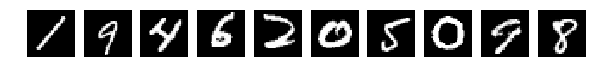

Reconstructions:


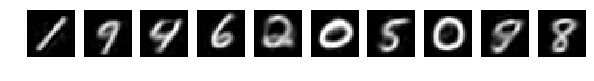

Generated Images:


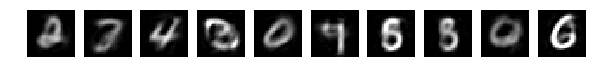

Train | Epoch: 8 [0/60000 (0%)]	Loss: 31.674772
Train | Epoch: 8 [12800/60000 (21%)]	Loss: 32.307312
Train | Epoch: 8 [25600/60000 (43%)]	Loss: 31.603050
Train | Epoch: 8 [38400/60000 (64%)]	Loss: 29.765106
Train | Epoch: 8 [51200/60000 (85%)]	Loss: 29.779350
====> Train | Epoch: 8 	 | 	 Average loss: 31.5545
====> Test  | model loss: 30.8745
Inputs:


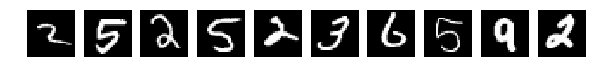

Reconstructions:


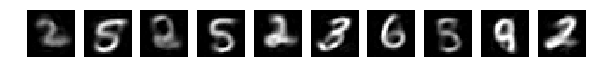

Generated Images:


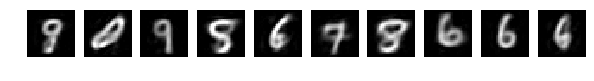

Train | Epoch: 9 [0/60000 (0%)]	Loss: 32.073044
Train | Epoch: 9 [12800/60000 (21%)]	Loss: 30.405565
Train | Epoch: 9 [25600/60000 (43%)]	Loss: 31.228001
Train | Epoch: 9 [38400/60000 (64%)]	Loss: 31.967859
Train | Epoch: 9 [51200/60000 (85%)]	Loss: 30.452007
====> Train | Epoch: 9 	 | 	 Average loss: 31.2751
====> Test  | model loss: 30.6381
Inputs:


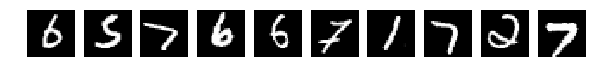

Reconstructions:


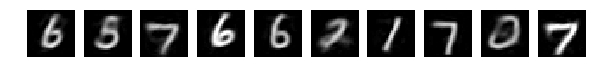

Generated Images:


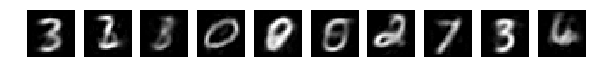

Train | Epoch: 10 [0/60000 (0%)]	Loss: 31.671036
Train | Epoch: 10 [12800/60000 (21%)]	Loss: 31.483568
Train | Epoch: 10 [25600/60000 (43%)]	Loss: 31.516220
Train | Epoch: 10 [38400/60000 (64%)]	Loss: 29.821135
Train | Epoch: 10 [51200/60000 (85%)]	Loss: 31.783916
====> Train | Epoch: 10 	 | 	 Average loss: 31.0431
====> Test  | model loss: 30.5234
Inputs:


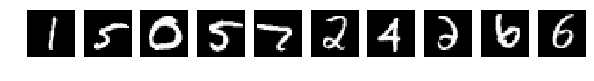

Reconstructions:


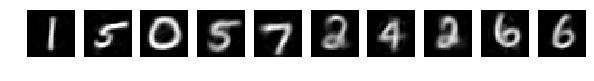

Generated Images:


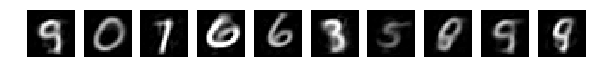

Train | Epoch: 11 [0/60000 (0%)]	Loss: 30.824539
Train | Epoch: 11 [12800/60000 (21%)]	Loss: 30.373907
Train | Epoch: 11 [25600/60000 (43%)]	Loss: 30.310478
Train | Epoch: 11 [38400/60000 (64%)]	Loss: 30.108725
Train | Epoch: 11 [51200/60000 (85%)]	Loss: 32.290874
====> Train | Epoch: 11 	 | 	 Average loss: 30.8401
====> Test  | model loss: 30.2472
Inputs:


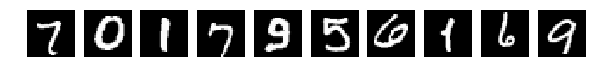

Reconstructions:


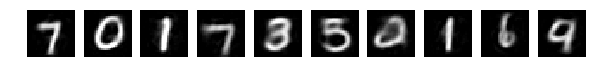

Generated Images:


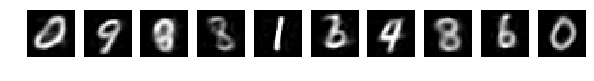

Train | Epoch: 12 [0/60000 (0%)]	Loss: 32.300728
Train | Epoch: 12 [12800/60000 (21%)]	Loss: 31.138039
Train | Epoch: 12 [25600/60000 (43%)]	Loss: 30.719191
Train | Epoch: 12 [38400/60000 (64%)]	Loss: 30.412794
Train | Epoch: 12 [51200/60000 (85%)]	Loss: 32.436218
====> Train | Epoch: 12 	 | 	 Average loss: 30.6740
====> Test  | model loss: 30.1878
Inputs:


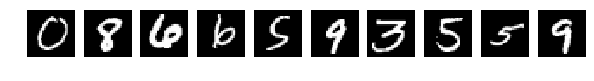

Reconstructions:


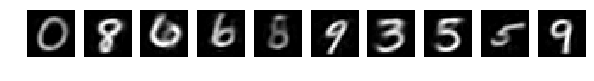

Generated Images:


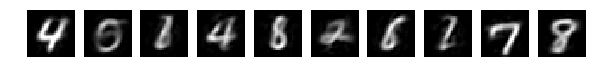

Train | Epoch: 13 [0/60000 (0%)]	Loss: 30.922361
Train | Epoch: 13 [12800/60000 (21%)]	Loss: 28.182173
Train | Epoch: 13 [25600/60000 (43%)]	Loss: 31.281357
Train | Epoch: 13 [38400/60000 (64%)]	Loss: 30.623268
Train | Epoch: 13 [51200/60000 (85%)]	Loss: 29.657143
====> Train | Epoch: 13 	 | 	 Average loss: 30.5690
====> Test  | model loss: 30.0189
Inputs:


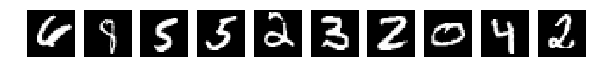

Reconstructions:


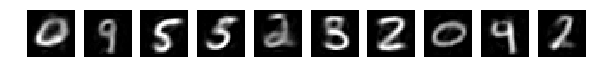

Generated Images:


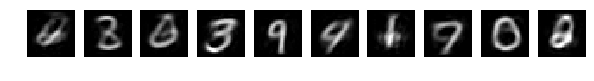

Train | Epoch: 14 [0/60000 (0%)]	Loss: 30.985855
Train | Epoch: 14 [12800/60000 (21%)]	Loss: 30.219522
Train | Epoch: 14 [25600/60000 (43%)]	Loss: 29.860435
Train | Epoch: 14 [38400/60000 (64%)]	Loss: 30.092052
Train | Epoch: 14 [51200/60000 (85%)]	Loss: 30.276773
====> Train | Epoch: 14 	 | 	 Average loss: 30.4187
====> Test  | model loss: 29.9746
Inputs:


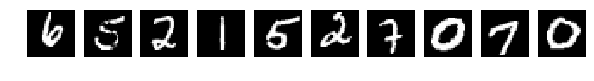

Reconstructions:


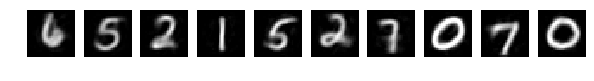

Generated Images:


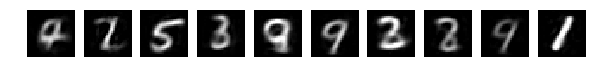

Train | Epoch: 15 [0/60000 (0%)]	Loss: 30.893330
Train | Epoch: 15 [12800/60000 (21%)]	Loss: 29.785419
Train | Epoch: 15 [25600/60000 (43%)]	Loss: 30.364681
Train | Epoch: 15 [38400/60000 (64%)]	Loss: 29.034643
Train | Epoch: 15 [51200/60000 (85%)]	Loss: 30.238016
====> Train | Epoch: 15 	 | 	 Average loss: 30.3192
====> Test  | model loss: 29.8786
Inputs:


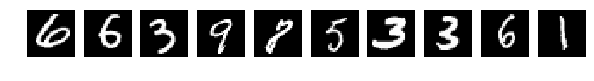

Reconstructions:


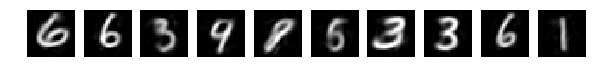

Generated Images:


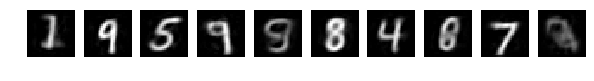

Train | Epoch: 16 [0/60000 (0%)]	Loss: 30.250452
Train | Epoch: 16 [12800/60000 (21%)]	Loss: 30.102577
Train | Epoch: 16 [25600/60000 (43%)]	Loss: 30.729141
Train | Epoch: 16 [38400/60000 (64%)]	Loss: 30.994980
Train | Epoch: 16 [51200/60000 (85%)]	Loss: 28.072271
====> Train | Epoch: 16 	 | 	 Average loss: 30.2041
====> Test  | model loss: 29.7113
Inputs:


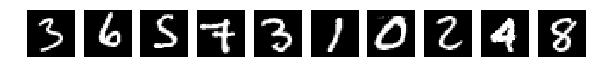

Reconstructions:


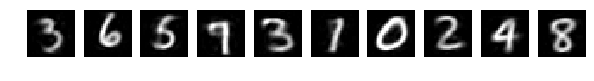

Generated Images:


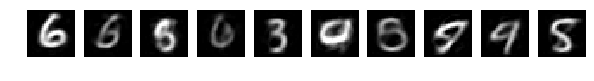

Train | Epoch: 17 [0/60000 (0%)]	Loss: 28.795696
Train | Epoch: 17 [12800/60000 (21%)]	Loss: 29.952803
Train | Epoch: 17 [25600/60000 (43%)]	Loss: 30.528080
Train | Epoch: 17 [38400/60000 (64%)]	Loss: 30.290512
Train | Epoch: 17 [51200/60000 (85%)]	Loss: 31.136169
====> Train | Epoch: 17 	 | 	 Average loss: 30.1294
====> Test  | model loss: 29.6346
Inputs:


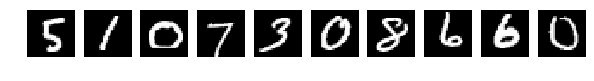

Reconstructions:


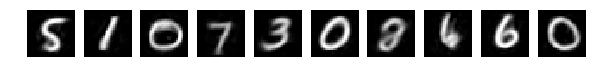

Generated Images:


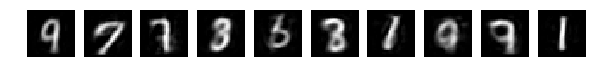

Train | Epoch: 18 [0/60000 (0%)]	Loss: 31.248789
Train | Epoch: 18 [12800/60000 (21%)]	Loss: 29.470415
Train | Epoch: 18 [25600/60000 (43%)]	Loss: 29.090740
Train | Epoch: 18 [38400/60000 (64%)]	Loss: 30.505154
Train | Epoch: 18 [51200/60000 (85%)]	Loss: 30.502659
====> Train | Epoch: 18 	 | 	 Average loss: 30.0427
====> Test  | model loss: 29.7204
Inputs:


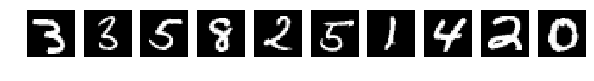

Reconstructions:


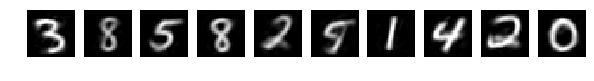

Generated Images:


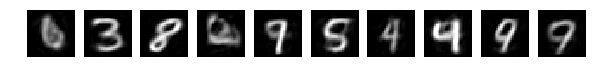

Train | Epoch: 19 [0/60000 (0%)]	Loss: 29.386272
Train | Epoch: 19 [12800/60000 (21%)]	Loss: 29.747179
Train | Epoch: 19 [25600/60000 (43%)]	Loss: 29.393204
Train | Epoch: 19 [38400/60000 (64%)]	Loss: 29.464937
Train | Epoch: 19 [51200/60000 (85%)]	Loss: 30.221634
====> Train | Epoch: 19 	 | 	 Average loss: 29.9802
====> Test  | model loss: 29.5359
Inputs:


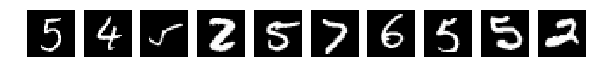

Reconstructions:


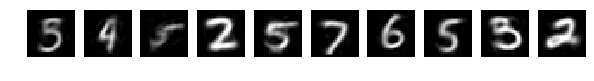

Generated Images:


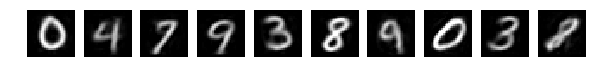

Train | Epoch: 20 [0/60000 (0%)]	Loss: 29.506744
Train | Epoch: 20 [12800/60000 (21%)]	Loss: 31.168062
Train | Epoch: 20 [25600/60000 (43%)]	Loss: 30.452892
Train | Epoch: 20 [38400/60000 (64%)]	Loss: 30.045027
Train | Epoch: 20 [51200/60000 (85%)]	Loss: 31.078270
====> Train | Epoch: 20 	 | 	 Average loss: 29.8860
====> Test  | model loss: 29.4252
Inputs:


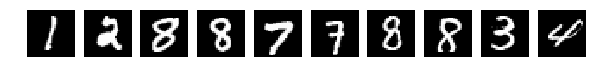

Reconstructions:


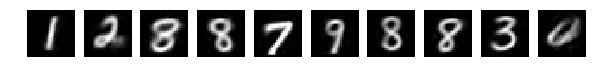

Generated Images:


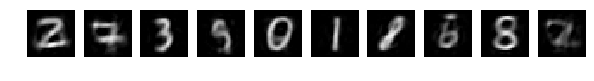

Train | Epoch: 21 [0/60000 (0%)]	Loss: 27.760124
Train | Epoch: 21 [12800/60000 (21%)]	Loss: 31.257565
Train | Epoch: 21 [25600/60000 (43%)]	Loss: 29.703009
Train | Epoch: 21 [38400/60000 (64%)]	Loss: 29.521149
Train | Epoch: 21 [51200/60000 (85%)]	Loss: 29.726963
====> Train | Epoch: 21 	 | 	 Average loss: 29.8293
====> Test  | model loss: 29.4248
Inputs:


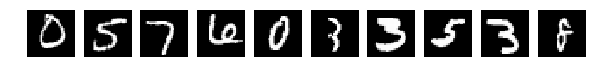

Reconstructions:


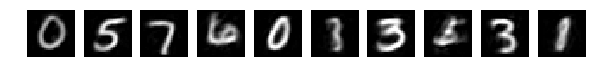

Generated Images:


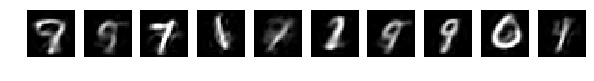

Train | Epoch: 22 [0/60000 (0%)]	Loss: 30.620966
Train | Epoch: 22 [12800/60000 (21%)]	Loss: 29.386662
Train | Epoch: 22 [25600/60000 (43%)]	Loss: 29.006701
Train | Epoch: 22 [38400/60000 (64%)]	Loss: 28.890991
Train | Epoch: 22 [51200/60000 (85%)]	Loss: 30.498333
====> Train | Epoch: 22 	 | 	 Average loss: 29.7765
====> Test  | model loss: 29.3935
Inputs:


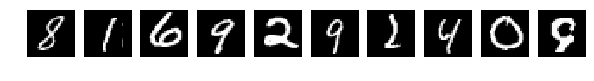

Reconstructions:


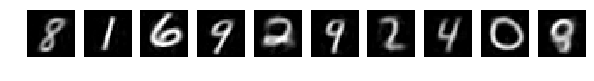

Generated Images:


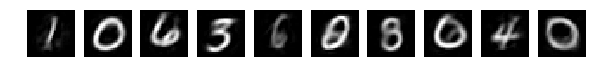

Train | Epoch: 23 [0/60000 (0%)]	Loss: 30.900476
Train | Epoch: 23 [12800/60000 (21%)]	Loss: 30.547401
Train | Epoch: 23 [25600/60000 (43%)]	Loss: 31.228794
Train | Epoch: 23 [38400/60000 (64%)]	Loss: 31.095272
Train | Epoch: 23 [51200/60000 (85%)]	Loss: 27.803457
====> Train | Epoch: 23 	 | 	 Average loss: 29.6837
====> Test  | model loss: 29.2735
Inputs:


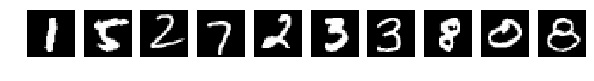

Reconstructions:


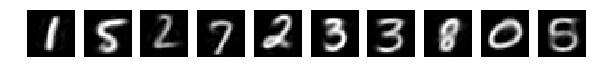

Generated Images:


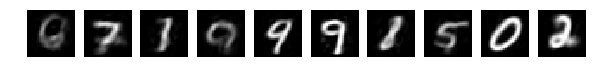

Train | Epoch: 24 [0/60000 (0%)]	Loss: 28.020073
Train | Epoch: 24 [12800/60000 (21%)]	Loss: 28.759937
Train | Epoch: 24 [25600/60000 (43%)]	Loss: 28.797291
Train | Epoch: 24 [38400/60000 (64%)]	Loss: 28.507975
Train | Epoch: 24 [51200/60000 (85%)]	Loss: 29.547184
====> Train | Epoch: 24 	 | 	 Average loss: 29.6535
====> Test  | model loss: 29.2723
Inputs:


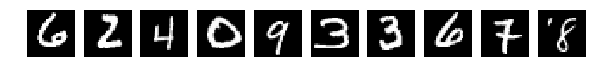

Reconstructions:


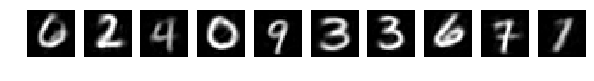

Generated Images:


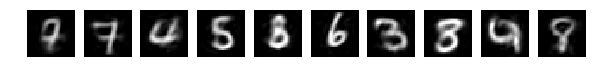

Train | Epoch: 25 [0/60000 (0%)]	Loss: 28.945192
Train | Epoch: 25 [12800/60000 (21%)]	Loss: 29.336149
Train | Epoch: 25 [25600/60000 (43%)]	Loss: 29.403358
Train | Epoch: 25 [38400/60000 (64%)]	Loss: 29.922792
Train | Epoch: 25 [51200/60000 (85%)]	Loss: 30.224472
====> Train | Epoch: 25 	 | 	 Average loss: 29.5752
====> Test  | model loss: 29.1768
Inputs:


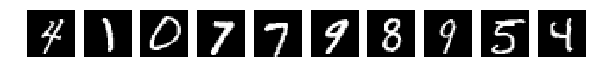

Reconstructions:


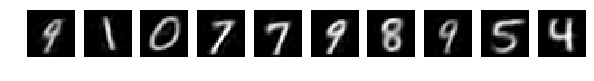

Generated Images:


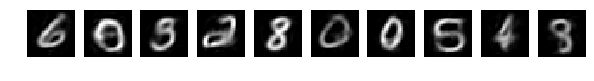

Train | Epoch: 26 [0/60000 (0%)]	Loss: 30.827431
Train | Epoch: 26 [12800/60000 (21%)]	Loss: 28.783876
Train | Epoch: 26 [25600/60000 (43%)]	Loss: 29.656012
Train | Epoch: 26 [38400/60000 (64%)]	Loss: 29.001648
Train | Epoch: 26 [51200/60000 (85%)]	Loss: 29.743290
====> Train | Epoch: 26 	 | 	 Average loss: 29.5535
====> Test  | model loss: 29.1181
Inputs:


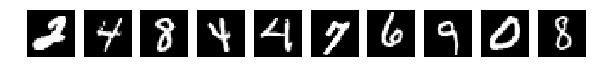

Reconstructions:


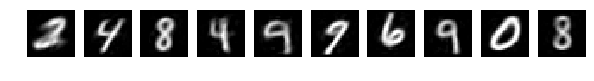

Generated Images:


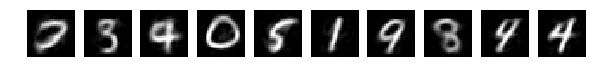

Train | Epoch: 27 [0/60000 (0%)]	Loss: 29.262362
Train | Epoch: 27 [12800/60000 (21%)]	Loss: 29.176609
Train | Epoch: 27 [25600/60000 (43%)]	Loss: 30.537018
Train | Epoch: 27 [38400/60000 (64%)]	Loss: 30.042770
Train | Epoch: 27 [51200/60000 (85%)]	Loss: 27.409624
====> Train | Epoch: 27 	 | 	 Average loss: 29.5192
====> Test  | model loss: 29.0540
Inputs:


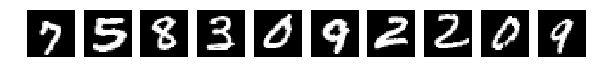

Reconstructions:


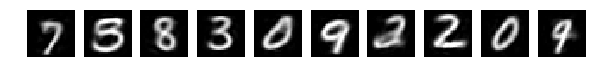

Generated Images:


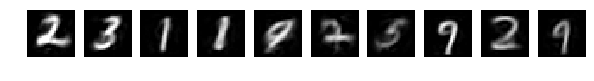

Train | Epoch: 28 [0/60000 (0%)]	Loss: 28.621759
Train | Epoch: 28 [12800/60000 (21%)]	Loss: 28.720909
Train | Epoch: 28 [25600/60000 (43%)]	Loss: 30.010376
Train | Epoch: 28 [38400/60000 (64%)]	Loss: 31.213686
Train | Epoch: 28 [51200/60000 (85%)]	Loss: 28.944115
====> Train | Epoch: 28 	 | 	 Average loss: 29.4719
====> Test  | model loss: 28.9850
Inputs:


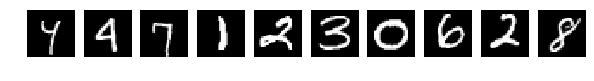

Reconstructions:


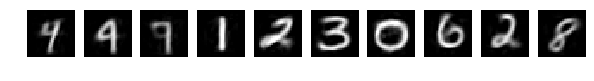

Generated Images:


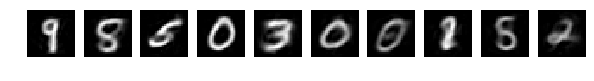

Train | Epoch: 29 [0/60000 (0%)]	Loss: 27.938358
Train | Epoch: 29 [12800/60000 (21%)]	Loss: 30.066685
Train | Epoch: 29 [25600/60000 (43%)]	Loss: 29.723461
Train | Epoch: 29 [38400/60000 (64%)]	Loss: 29.748398
Train | Epoch: 29 [51200/60000 (85%)]	Loss: 30.398064
====> Train | Epoch: 29 	 | 	 Average loss: 29.4334
====> Test  | model loss: 28.9943
Inputs:


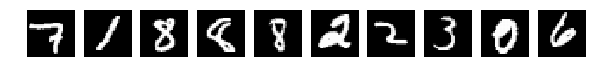

Reconstructions:


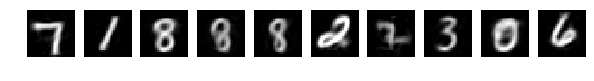

Generated Images:


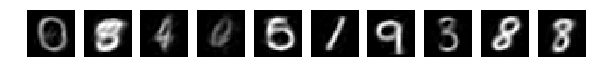

Train | Epoch: 30 [0/60000 (0%)]	Loss: 29.162941
Train | Epoch: 30 [12800/60000 (21%)]	Loss: 27.985447
Train | Epoch: 30 [25600/60000 (43%)]	Loss: 28.993683
Train | Epoch: 30 [38400/60000 (64%)]	Loss: 28.306562
Train | Epoch: 30 [51200/60000 (85%)]	Loss: 29.847826
====> Train | Epoch: 30 	 | 	 Average loss: 29.3773
====> Test  | model loss: 29.0780
Inputs:


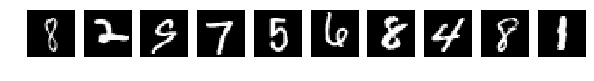

Reconstructions:


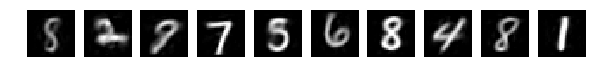

Generated Images:


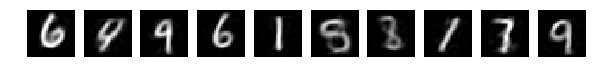

In [15]:
n_epoch = 30
run(vae, vae.parameters(), n_epoch, train_loader, test_loader,
   end_function=show_vae)

---

In [0]:
def check_interpolations(model, n_rows, n_cols):
    """
    Write a function which interpolates 10 images between two random mnist image
    """
    plt.rcParams['figure.figsize'] = (0.0 + n_cols, 0.0 + n_rows) # set default size of plots
    
    data_loader = train_loader
    
    for _ in range(n_rows):
        indices = torch.randint(data_loader.dataset.tensors[0].shape[0], (2,))
        img_1 = data_loader.dataset.tensors[0][indices][:1].flatten(start_dim=1)
        img_2 = data_loader.dataset.tensors[0][indices][1:].flatten(start_dim=1)
        
        ########################## TODO ##########################
        # Output `n_cols` images.
        # First one should be img_1. Last one should by img_2
        # Let z_1 and z_2 be latent tensors of img_1 and img_2
        # Interpolate (n_cols - 2) tensors between z_1 and z_2
        # Intermediate images must be the result of applying decoder on these (n_cols - 2) tensors
        
        z_1 = vae({"X": img_1.cuda()})["z"].detach()
        z_2 = vae({"X": img_2.cuda()})["z"].detach()
        
        
        ttt=torch.tensor( (np.arange(n_cols)/(n_cols-1)).reshape(-1,1) , dtype=torch.float32 ).cuda()  
        output=model.decoder(ttt*(z_2-z_1)+z_1).detach().cpu().view(-1, 28, 28).numpy()

        ######################## END TODO ########################
        
        show(output)

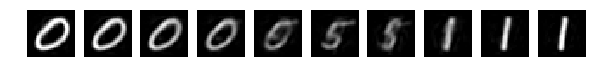

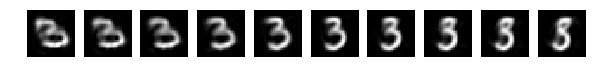

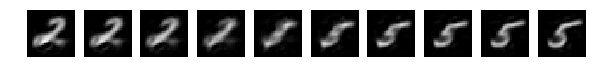

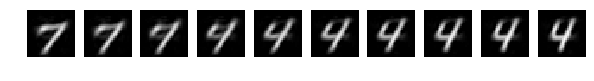

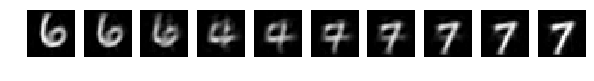

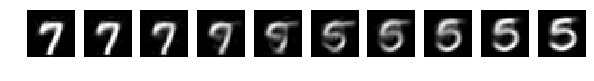

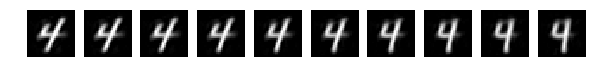

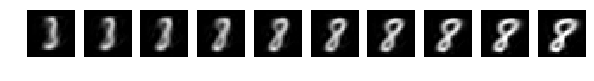

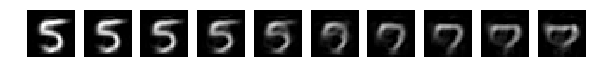

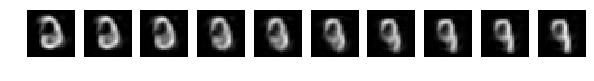

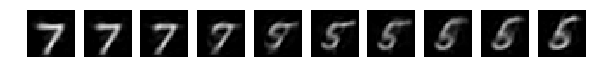

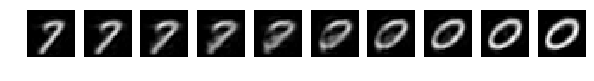

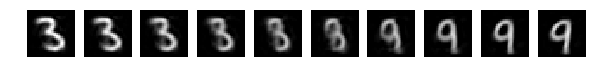

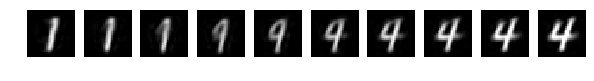

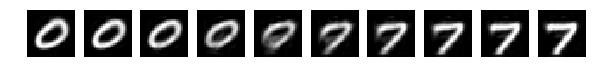

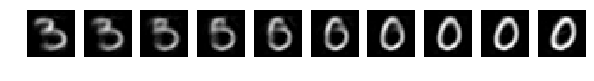

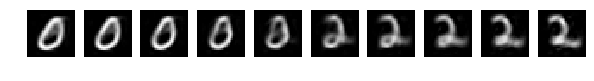

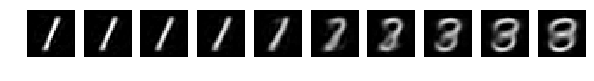

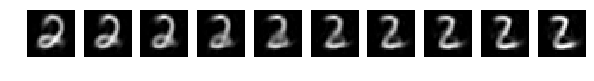

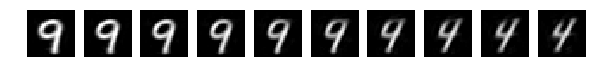

In [102]:
check_interpolations(vae, 20, 10)